In [5]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np




## ImageLoader 

Guardamos las imagenes de en un diccionario para facilitar el acceso

In [6]:

class ImageLoader:
    def __init__(self, folder_path, is_gray=False):
        """
        Initializes ImageLoader with folder path and color option.

        Args:
          folder_path (str): Path to the folder containing images.
          is_gray (bool, optional): Whether to load images in grayscale.
        """
        self.folder_path = folder_path
        self.is_gray = is_gray
        self.images = {}

    def load(self):
        """
        Loads images from the specified folder.

        Returns:
          dict: A dictionary of loaded images with filenames as keys.
        """
        for filename in os.listdir(self.folder_path):
            if filename.endswith((".jpg", ".png")):
                file_path = os.path.join(self.folder_path, filename)
                name, _ = os.path.splitext(filename)
                self.images[name] = cv2.imread(file_path, 0 if self.is_gray else 1)
        return self.images



## ImagePlotter 

Agrupamos todas las funciones para ver las imagenes del diccionario


In [7]:

class ImagePlotter:
    def __init__(self, images):
        """
        Initializes ImagePlotter with a dictionary of images.

        Args:
          images (dict): Dictionary of images with filenames as keys.
        """
        self.images = images

    def plot(self, titles=None, title="", rows=1, cols=None, figsize=5, is_gray=False, cmap="gray"):
        """
        Plots the images.

        Args:
          titles (list, optional): List of titles for each image.
          title (str, optional): Main title for the plot.
          rows (int, optional): Number of rows in the plot grid.
          cols (int, optional): Number of columns in the plot grid.
          figsize (int, optional): Size of each image in the plot.
          is_gray (bool, optional): Whether images are in grayscale.
          cmap (str, optional): Colormap for grayscale images.
        """
        if not self.images:
            print("No images to plot.")
            return

        cols = len(self.images) if not cols else cols
        titles = titles or list(self.images.keys())

        fig, axes = plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))
        fig.suptitle(title, fontsize=16, fontweight="bold")

        for i, (img_name, image) in enumerate(self.images.items()):
            ax = axes[i] if rows == 1 else axes[i // cols, i % cols]
            if is_gray:
                ax.imshow(image, cmap=cmap)
            else:
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax.set_title(titles[i], fontsize=int(figsize * 2.5))
            ax.axis("off")

        plt.tight_layout()
        plt.show()


## BoxCalculator 

Implementamos Intersection over Union (IoU) en una clase separada para simplificar NonMaximumSuppression().

In [8]:

class BoxCalculator:
    @staticmethod
    def calculate_iou_batch(boxes_a: np.ndarray, boxes_b: np.ndarray) -> np.ndarray:
        """
        Calculates Intersection over Union (IoU) between two sets of boxes.

        Args:
          boxes_a (numpy.ndarray): First set of boxes, shape (N, 4).
          boxes_b (numpy.ndarray): Second set of boxes, shape (M, 4).

        Returns:
          numpy.ndarray: IoU matrix, shape (N, M).
        """
        def box_area(box):
            return (box[2] - box[0]) * (box[3] - box[1])

        area_a = box_area(boxes_a.T)
        area_b = box_area(boxes_b.T)

        top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
        bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

        area_inter = np.prod(np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        return area_inter / (area_a[:, None] + area_b - area_inter) 


## NonMaximumSuppression 

Usamos BoxCalculator para medir la superposición de dos zonas de detección y eliminamos las que se solapen mas de un 80%

In [9]:

class NonMaximumSuppression:
    @staticmethod
    def suppress(matches, iou_threshold=0.8):
        """
        Applies non-maximum suppression to filter overlapping bounding boxes.

        Args:
          matches (numpy.ndarray): Array of matches, each row containing
                                   [x1, y1, x2, y2, match_value].
          iou_threshold (float, optional): IoU threshold for suppression.

        Returns:
          numpy.ndarray: Filtered matches.
        """
        def is_contained(box_a, box_b):
            """
            Checks if box_a is fully contained within box_b.

            Args:
              box_a (numpy.ndarray): First box coordinates [x1, y1, x2, y2].
              box_b (numpy.ndarray): Second box coordinates [x1, y1, x2, y2].

            Returns:
              bool: True if box_a is contained in box_b, False otherwise.
            """
            x1_in = box_a[0] > box_b[0]
            y1_in = box_a[1] > box_b[1]
            x2_in = box_a[2] < box_b[2]
            y2_in = box_a[3] < box_b[3]
            return all([x1_in, y1_in, x2_in, y2_in])

        rows = matches.shape[0]
        if rows == 0:
            return matches

        sort_index = np.flip(matches[:, 4].argsort())
        matches_sorted = matches[sort_index]

        boxes = matches_sorted[:, :4]
        ious = BoxCalculator.calculate_iou_batch(boxes, boxes)
        ious = ious - np.eye(rows)

        keep = np.ones(rows, dtype=bool)
        for index, iou in enumerate(ious):
            if not keep[index]:
                continue
            condition = iou > iou_threshold
            keep = keep & ~condition

        return matches_sorted[keep]




## ImageAnnotator 
 Vamos a mostrar el valor de la métrica utilizada en TempleMatching que corresponde al ROI encontrado en cada instancia detectada


In [10]:

class ImageAnnotator:
    @staticmethod
    def annotate(img, xyxy, text, font=cv2.FONT_HERSHEY_SIMPLEX):
        """
        Annotates an image with a bounding box and text.

        Args:
          img: The image to annotate.
          xyxy (tuple): Bounding box coordinates (x1, y1, x2, y2).
          text (str): Text to display next to the bounding box.
          font (int, optional): OpenCV font type.
        """
        x1, y1, x2, y2 = xyxy

        thickness = int(max(img.shape) / 180)
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=thickness)

        scale = thickness / 4
        text_width, text_height = cv2.getTextSize(
            text=text, fontFace=font, fontScale=scale, thickness=thickness
        )[0]

        text_x = x1 + thickness
        text_y = y1 - thickness

        text_background_x1 = x1
        text_background_y1 = y1 - 2 * thickness - text_height

        text_background_x2 = x1 + 2 * thickness + text_width
        text_background_y2 = y1

        cv2.rectangle(
            img=img,
            pt1=(text_background_x1, text_background_y1),
            pt2=(text_background_x2, text_background_y2),
            color=(0, 255, 0),
            thickness=cv2.FILLED,
        )
        cv2.putText(
            img=img,
            text=text,
            org=(text_x, text_y),
            fontFace=font,
            fontScale=scale,
            color=(255, 255, 255),
            thickness=thickness,
            lineType=cv2.LINE_AA,
        )
        return img


## TemplateMatcher Class

Combinamos en una sola clase la detección única y multiple para homologar la interfaz

In [11]:

class TemplateMatcher:
    def __init__(self, template, method):
        """
        Initializes TemplateMatcher with template image and matching method.

        Args:
          template: The template image.
          method: The template matching method (e.g., cv2.TM_CCOEFF_NORMED).
        """
        
        self.template = self._get_image_border(template)  # Apply border extraction to template
        self.method = method

    def match(self, img, min_scale=1, max_scale=1, n_scales=1, threshold=0.9, iou_threshold=0.5, multi=False):
        """
        Performs template matching on the input image.

        Args:
          img: The input image.
          min_scale: The minimum scaling factor.
          max_scale: The maximum scaling factor.
          n_scales: The number of scales to try between min_scale and max_scale.
          threshold: The threshold for filtering matches (used in multi_match).
          iou_threshold: The IoU threshold for non-maximum suppression (used in multi_match).
          multi (bool): Whether to perform single or multiple matches.

        Returns:
          numpy.ndarray: Array of matches.
        """
        if multi:
            return self.multi_match(img, min_scale, max_scale, n_scales, threshold, iou_threshold)
        else:
            return self.single_match(img, min_scale, max_scale, n_scales)

    def single_match(self, img, min_scale=1, max_scale=1, n_scales=1):
        """
        Performs single template matching on the input image.

        Args:
          img: The input image.
          min_scale: The minimum scaling factor.
          max_scale: The maximum scaling factor.
          n_scales: The number of scales to try between min_scale and max_scale.

        Returns:
          numpy.ndarray: Array containing the bounding box coordinates and the maximum matching value.
        """
        scales = np.linspace(max_scale, min_scale, n_scales)
        best_val = 0
        best_bbox = None

        for scale in scales:
            img_scaled = cv2.resize(img, None, fx=scale, fy=scale)
            if self._is_template_too_big(self.template, img_scaled):
                break

            img_border = self._get_image_border(img_scaled)
            match = cv2.matchTemplate(img_border, self.template, self.method)
            _, max_val, _, top_left = cv2.minMaxLoc(match)

            if max_val > best_val:
                best_val = max_val
                bottom_right = (top_left[0] + self.template.shape[1], top_left[1] + self.template.shape[0])
                bbox_scaled = np.array([top_left[0], top_left[1], bottom_right[0], bottom_right[1]])
                best_bbox = (bbox_scaled / scale).astype(int)

        return np.hstack((best_bbox, best_val))

    def multi_match(self, img, min_scale=1, max_scale=1, n_scales=1, threshold=0.9, iou_threshold=0.5):
        """
        Performs multiple template matching on the input image with non-maximum suppression.

        Args:
          img: The input image.
          min_scale: The minimum scaling factor.
          max_scale: The maximum scaling factor.
          n_scales: The number of scales to try between min_scale and max_scale.
          threshold: The threshold for filtering matches.
          iou_threshold: The IoU threshold for non-maximum suppression.

        Returns:
          numpy.ndarray: Array of matches, each row containing [x1, y1, x2, y2, match_value].
        """
        scales = np.linspace(max_scale, min_scale, n_scales)
        max_val = 0
        matches = np.zeros((1, 5))

        for scale in scales:
            img_scaled = cv2.resize(img, None, fx=scale, fy=scale)
            if self._is_template_too_big(self.template, img_scaled):
                break

            img_border = self._get_image_border(img_scaled)
            res = cv2.matchTemplate(img_border, self.template, self.method)

            max_val_img = np.max(res)
            max_val = max_val_img if max_val_img > max_val else max_val
            keep = res > (threshold * max_val)
            if not np.sum(keep):
                continue

            top_lefts = np.array([[x, y] for y, x in zip(*np.where(keep))])
            bottom_rights = top_lefts + np.array([self.template.shape[1], self.template.shape[0]])
            bboxes_img_scaled = np.hstack((top_lefts, bottom_rights))
            bboxes_img = (bboxes_img_scaled / scale).astype(int)

            vals_img = np.array([[val] for val in res[keep].flatten()])
            matches_img = np.hstack((bboxes_img, vals_img))
            matches = np.vstack((matches, matches_img))

            keep = matches[:, 4] > (threshold * max_val)
            matches = matches[keep.flatten()]

            # Filter in each iteration to avoid 'out of memory' error.
            matches = NonMaximumSuppression.suppress(matches=matches, iou_threshold=iou_threshold)

        return matches

    def _get_image_border(self, img):
        """
        Extracts the borders of an image using Canny edge detection.

        Args:
          img: The input image.

        Returns:
          The image with edges highlighted.
        """
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.GaussianBlur(img_gray, ksize=(3, 3), sigmaX=1, sigmaY=1)
        img_border = cv2.Canny(img_gray, threshold1=5, threshold2=200)
        return img_border

    def _is_template_too_big(self, template, img):
        """
        Checks if the template is larger than the image.

        Args:
          template: The template image.
          img: The image to compare against.

        Returns:
          bool: True if the template is too big, False otherwise.
        """
        return template.shape[0] > img.shape[0] or template.shape[1] > img.shape[1]


## Prueba de detección única (punto 1)

In [12]:

# Load images
image_loader = ImageLoader(r"C:\Users\dimas\OneDrive\Escritorio\VpC1 TP3\source\images")
images = image_loader.load()


In [13]:

# Load and process the template
template_path = r"C:\Users\dimas\OneDrive\Escritorio\VpC1 TP3\source\template"
template_filename = "pattern.png"
template_file_path = os.path.join(template_path, template_filename)
template = cv2.imread(template_file_path)



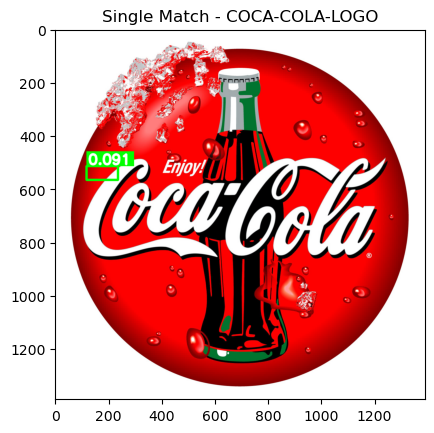

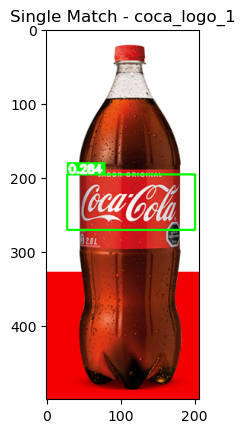

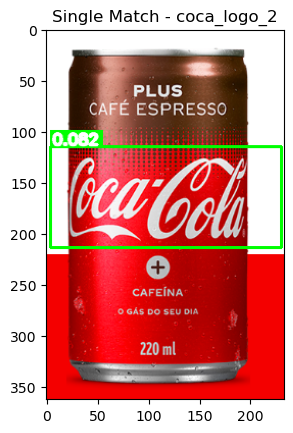

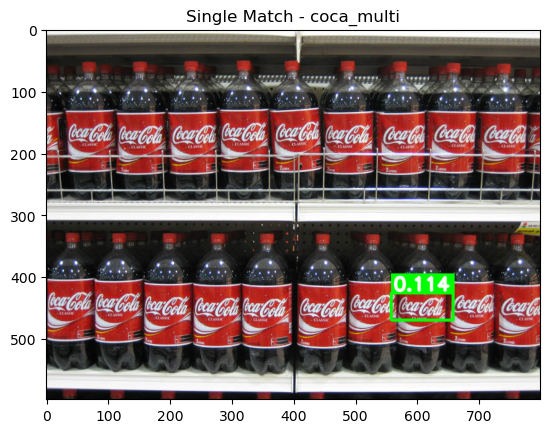

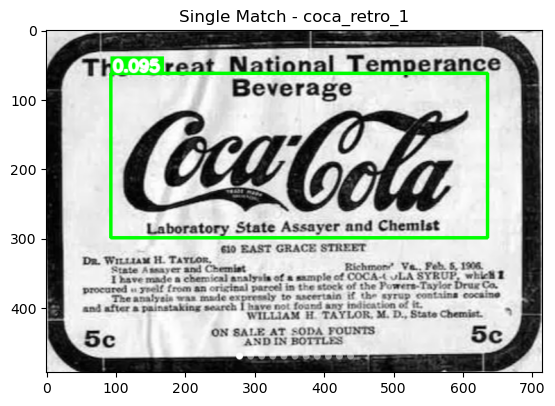

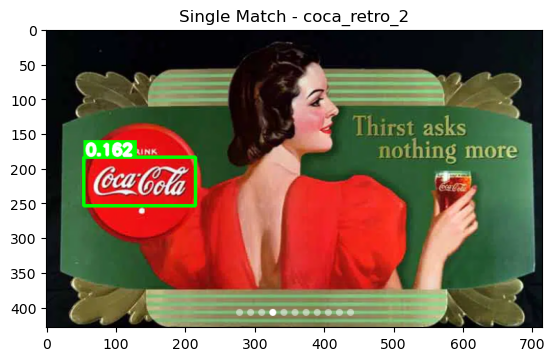

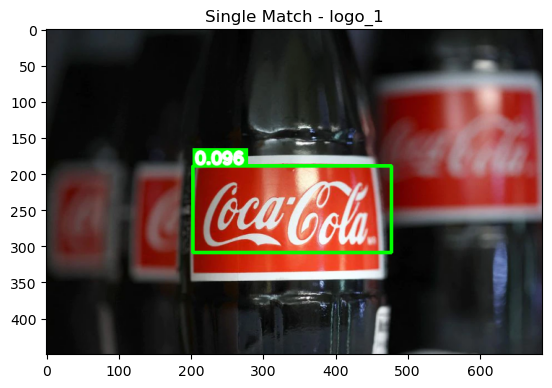

In [ ]:

# Perform template matching
method = cv2.TM_CCOEFF_NORMED
template_matcher = TemplateMatcher(template, method)

for img_name, img in images.items():
    # Example using single_match
    match = template_matcher.match(img, min_scale=0.3, max_scale=4, n_scales=50, threshold=0.85)
    
    # Check if a match was found
    if match is not None: 
        annotated_img = ImageAnnotator.annotate(img.copy(), match[:4].astype(int), str(round(match[4], 3)))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Single Match - {img_name}")
        plt.show()
    else:
        print(f"No match found for {img_name}")

Se puede ver que hubo un error en la detección del logo en la imagen con el logo mas grande. Puede deberse a que el area homogenea que presenta la tapita puede probocar una alta correlación pese a que no se produjo un match. 

# Prueba con multiple  (punto 2 y 3)

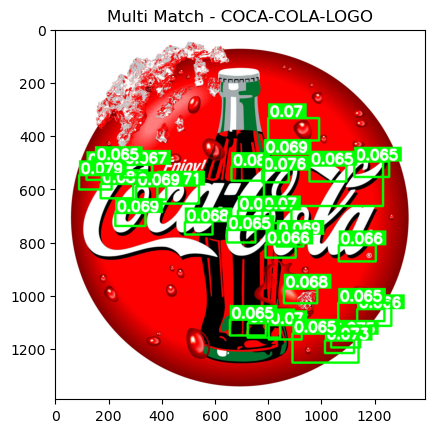

No matches found for coca_logo_1


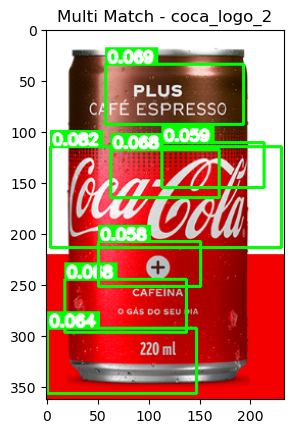

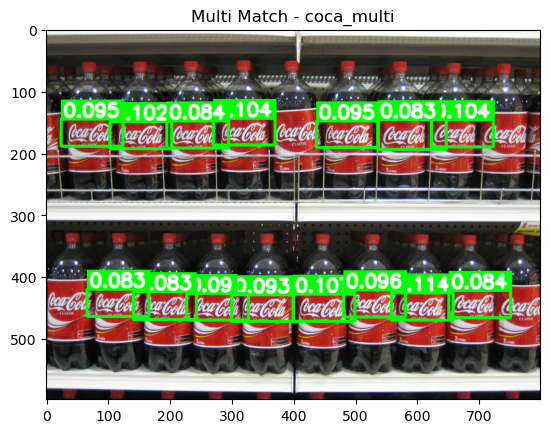

No matches found for coca_retro_1
No matches found for coca_retro_2


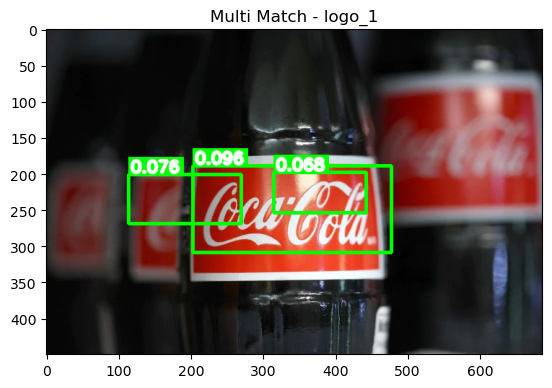

In [30]:

# Perform template matching
method = cv2.TM_CCOEFF_NORMED
template_matcher = TemplateMatcher(template, method)

for img_name, img in images.items():
    # Example using multi_match
    matches = template_matcher.match(img, min_scale=0.1, max_scale=4, n_scales=50, multi=True, threshold=0.7, iou_threshold=0.3)
    
    # Check if matches were found
    if matches.shape[0] > 1:  # Check if there are any matches besides the initial zero row
        annotated_img = img.copy()
        for match in matches:
            annotated_img = ImageAnnotator.annotate(annotated_img, match[:4].astype(int), str(round(match[4], 3)))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Multi Match - {img_name}")
        plt.show()
    else:
        print(f"No matches found for {img_name}")

Es complicado poder encontrar parámetros que generalicen bien a todas las imagenes. Podría realizarse otras alternativas más complejas como SIFT para tener un algorítmo mas robusto.

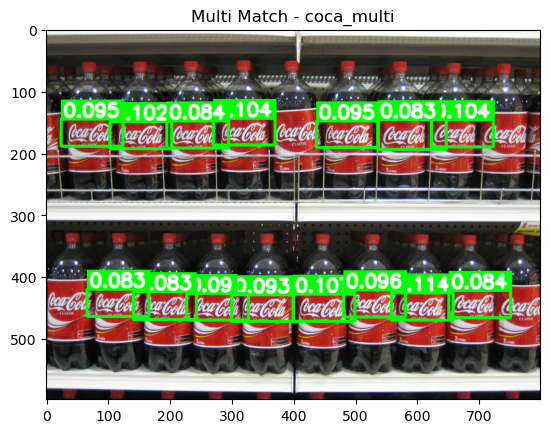

In [32]:
img_name = "coca_multi" 
matches = template_matcher.match(images[img_name], min_scale=0.1, max_scale=4, n_scales=50, multi=True, threshold=0.7)

annotated_img = images[img_name].copy()

for match in matches:

     annotated_img = ImageAnnotator.annotate(annotated_img, match[:4].astype(int), str(round(match[4], 3)))

plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))

plt.title(f"Multi Match - {img_name}")

plt.show()

Para una imagen en particular se puede ajustar mas fácil los umbrales y mejorar el desempeño del algorítmo